In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

     |████████████████████████████████| 1.6MB 2.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=c1e0c25a146f5f9df0f5390c0ab21b38bc51f06a1ff48cfc8a7e4748a57b2531
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
import pandas as pd
df=pd.read_csv('postlockdown.csv',keep_default_na=False)

In [3]:
df.isnull().sum()

id                    0
created_at            0
original_text         0
clean_text            0
polarity              0
subjectivity          0
favorite_count        0
retweet_count         0
possibly_sensitive    0
hashtags              0
user_mentions         0
place                 0
dtype: int64

In [4]:
df.head(5)

,id,created_at,original_text,clean_text,polarity,subjectivity,favorite_count,retweet_count,possibly_sensitive,hashtags,user_mentions,place
0,1302893126495932416,Mon Sep 07 08:55:02 +0000 2020,Air pollution is a threat to sustainable devel...,Air pollution threat sustainable development s...,0.186667,0.293333,395,210,False,WorldCleanAirDay,,
1,1302895825769689088,Mon Sep 07 09:05:46 +0000 2020,#WorldCleanAirDay What has been your contribut...,What contribution especially Take Action today,0.050000,0.550000,1,2,False,"WorldCleanAirDay, StareDownOnPollution, AirPol...",SustyVibes,"Lagos, Nigeria"
2,1309949367785320449,Sat Sep 26 20:14:01 +0000 2020,$YFMF community! Around 12 hours left YFMF is ...,YFMF community Around 12 hours left YFMF getti...,0.034091,0.243750,2244,2235,False,,,
3,1296446705920081922,Thu Aug 20 13:59:16 +0000 2020,#OstenLaboratory \n#Ostenlab \n\nThrow back Th...,Throw back Thursday We Osten Lagos Nigeria,0.000000,0.000000,0,0,False,"OstenLaboratory, Ostenlab, airquality, airqual...",,"Lagos, Nigeria"
4,1310147696150413314,Sun Sep 27 09:22:06 +0000 2020,#Bitcoin #cryptocurrency #AirQuality #BitcoinC...,,0.000000,0.000000,0,0,False,"Bitcoin, cryptocurrency, AirQuality, BitcoinCa...",,


In [7]:
!python --version

Python 3.6.9


In [8]:
from collections import Counter
hash_df=dict(Counter(df['hashtags'].to_list()))
top_hash_df=pd.DataFrame(list(hash_df.items()),columns = ['word','count']).sort_values('count',ascending=False)[:20]
top_hash_df.head(4)

,word,count
2,,9
56,CleanAirForAll,5
0,WorldCleanAirDay,3
51,"TheJamSession, FreshAIR, WCW, WednesdayVibes, ...",2


In [10]:
import plotly.graph_objs as go
fig = go.Figure(go.Bar(
    x=top_hash_df['word'],y=top_hash_df['count'],
    marker={'color': top_hash_df['count'], 
    'colorscale': 'blues'},  
    text=top_hash_df['count'],
    textposition = "outside",
))
fig.update_layout(title_text='Top Trended Hastags',xaxis_title="Hashtags",
                  yaxis_title="Number of Tags",template="plotly_dark",height=700,title_x=0.5)
fig.show()

In [11]:
type(df)

pandas.core.frame.DataFrame

In [12]:
data=df.clean_text.values.tolist()

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [14]:
data_words

[['air',
  'pollution',
  'threat',
  'sustainable',
  'development',
  'simultaneously',
  'affects',
  'various',
  'social',
  'environmental',
  'amp',
  'economic',
  'criteria',
  'linked',
  'equitable',
  'human',
  'development',
  'good',
  'health',
  'food',
  'security',
  'gender',
  'equality',
  'climate',
  'stability',
  'amp',
  'poverty',
  'reduction'],
 ['what', 'contribution', 'especially', 'take', 'action', 'today'],
 ['yfmf',
  'community',
  'around',
  'hours',
  'left',
  'yfmf',
  'getting',
  'list',
  'uniswap',
  'fasten',
  'seatbelts',
  'big',
  'ride',
  'yfmf',
  'private',
  'sale',
  'is',
  'live',
  'website',
  'verified',
  'contract',
  'yfmf',
  'telegram'],
 ['throw', 'back', 'thursday', 'we', 'osten', 'lagos', 'nigeria'],
 [],
 ['pre',
  'occuption',
  'clean',
  'service',
  'park',
  'view',
  'estate',
  'ikoyi',
  'island'],
 [],
 ['she', 'love', 'colours'],
 ['everywhere', 'calm', 'no', 'biggie', 'mary', 'martha', 'rema'],
 ['you',
  

In [15]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['nan', 'loans', 'loan', 'debt', 'use','student','char','students','000','also'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


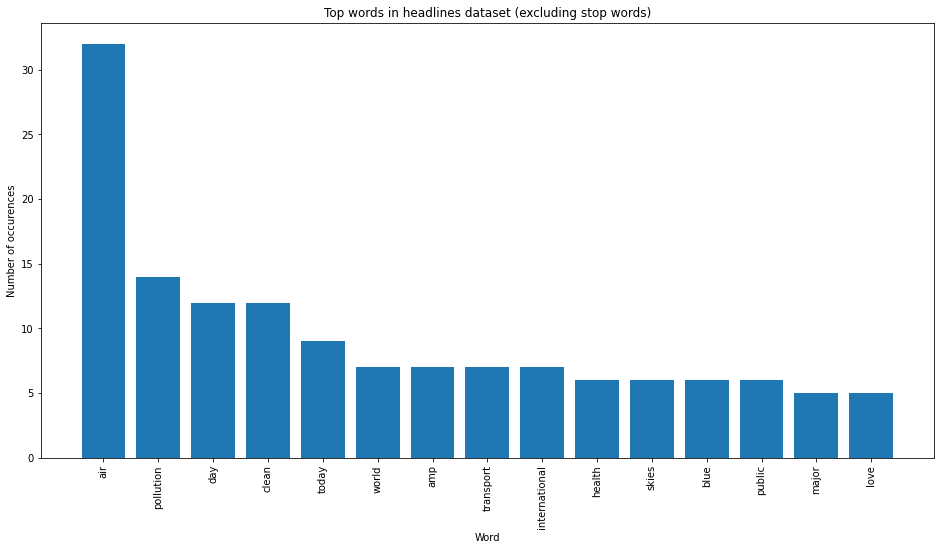

In [16]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values.astype('U'))
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])



count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df.clean_text)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

<Figure size 1152x936 with 0 Axes>

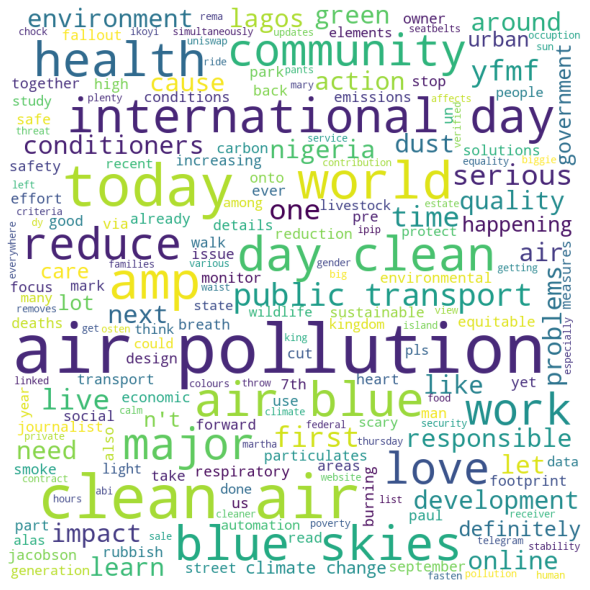

In [20]:
from wordcloud import WordCloud
plt.figure(figsize=(16,13))

# Python program to generate WordCloud for the clean_text column in the data


comment_words = '' 
#stopwords = set(STOPWORDS) 
#stopwords=stopwords.words('english')
# iterate through the csv file 
for val in df.clean_text: 

# typecaste each val to string 
    val = str(val) 

# split the value 
    tokens = val.split() 

# Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(comment_words) 

# plot the WordCloud image 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [21]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df
unigram_df=ngram_df(df['clean_text'],(1,1),20)
bigram_df=ngram_df(df['clean_text'],(2,2),20)
trigram_df=ngram_df(df['clean_text'],(3,3),20)

In [22]:

#plots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ",
                  showlegend=False,title_x=0.5,height=1200,template="plotly_dark")
fig.show()

<Figure size 1152x936 with 0 Axes>

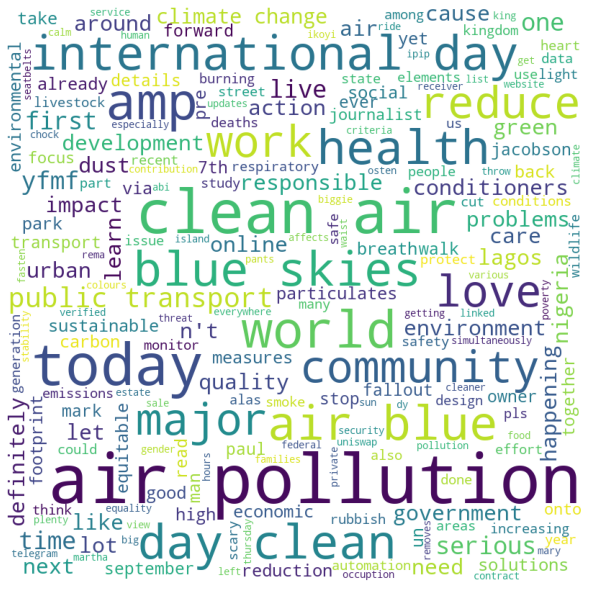

In [25]:
plt.figure(figsize=(16,13))

# Python program to generate WordCloud for the body column in the data


comment_words = '' 
stopwords = stop_words

# iterate through the csv file 
for val in df.clean_text: 

# typecaste each val to string 
    val = str(val) 

# split the value 
    tokens = val.split() 

# Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 

# plot the WordCloud image 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [26]:
train_data=df['clean_text'].to_frame()
print(train_data)

                                           clean_text
0   Air pollution threat sustainable development s...
1      What contribution especially Take Action today
2   YFMF community Around 12 hours left YFMF getti...
3          Throw back Thursday We Osten Lagos Nigeria
4                                                    
..                                                ...
76  Nema accomplices saga I seen letter wrote Buny...
77                                      And 's scares
78  It definitely scary government serious could l...
79  Exactly ... But keep retracting statement time...
80  It definitely scary government serious could l...

[81 rows x 1 columns]


In [27]:
#Pre processing
#converting each string to a numerical vector using  CountVectorizer(feature construction)


count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
text_sample = train_data.sample(n=50, random_state=0).values.astype('U')
print(text_sample)
print('Body before vectorization: {}'.format(text_sample[1]))

document_term_matrix = count_vectorizer.fit_transform(text_sample.ravel())
print('Body after vectorization: \n{}'.format(document_term_matrix[1]))

[["reduces 'll responsible FEWER added Good Tuesday morning fellow \u200d️\u200d️"]
 ['After 15 years today last day Saturday Star I ’ blessed work learn incredible journalists made great friends grateful editors supported encouraged work Onto next exciting chapter environmental journalism']
 ['The basics Chillers']
 ['Are effective equitable solutions yet These 4 countries produce world largest Via']
 ['Happening Mr. Simon Kimutai Chair Matatu Owners Association Inspection vehicles done year need government invest technologies continuously monitor level emmissions public transport']
 ['The air breathe makes worry kids ’ health While many notice people care think There ’ urgent need raise among local people understand available data amp learn safety measures']
 ['Monday Movements OutDoor Chapterz Part 1 Hike Like Sunday wit Homeyz Modderfontein Reserve']
 ['Emissions transport sector major contributor climate change significant impact air quality What done mitigate issue Read']
 ['Few 

In [28]:
#clustering algorithm (Latent Semantic Analysis or Latent Dirichilet Allocation.)
#number of topic categories
n_topics=4

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [30]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [31]:
#Taking the  argmax  of each headline in this topic matrix will give the predicted topics of each headline in the sample. We can then sort these into counts of each topic.
from collections import Counter
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [32]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [33]:
print(document_term_matrix)

  (0, 302)	1
  (0, 315)	1
  (0, 137)	1
  (0, 13)	1
  (0, 157)	1
  (0, 379)	1
  (0, 244)	1
  (0, 136)	1
  (1, 2)	1
  (1, 402)	1
  (1, 373)	1
  (1, 205)	1
  (1, 95)	1
  (1, 326)	1
  (1, 349)	1
  (1, 43)	1
  (1, 397)	2
  (1, 207)	1
  (1, 181)	1
  (1, 195)	1
  (1, 226)	1
  (1, 161)	1
  (1, 149)	1
  (1, 160)	1
  (1, 109)	1
  :	:
  (48, 278)	1
  (48, 202)	1
  (48, 253)	1
  (48, 170)	1
  (48, 300)	1
  (48, 35)	1
  (48, 352)	2
  (48, 337)	1
  (48, 312)	1
  (48, 270)	1
  (48, 282)	1
  (48, 123)	1
  (48, 317)	1
  (48, 0)	1
  (48, 4)	1
  (48, 280)	1
  (48, 98)	1
  (48, 5)	1
  (48, 17)	1
  (49, 95)	1
  (49, 15)	1
  (49, 65)	1
  (49, 185)	1
  (49, 44)	1
  (49, 340)	1


In [34]:
# The topic categories are not that helpful in order to better
# categorize them ,we find the most frequent words in each
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum=[]
        temp_sum=0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_sum += document_term_matrix[i]
        temp_vector_sum.append(temp_sum)
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [36]:
top_n_words_lda = get_top_n_words(5, lda_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

IndexError: ignored

In [37]:
#Create Bigram and Trigram Models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['air', 'pollution', 'threat', 'sustainable', 'development', 'simultaneously', 'affects', 'various', 'social', 'environmental', 'amp', 'economic', 'criteria', 'linked', 'equitable', 'human', 'development', 'good', 'health', 'food', 'security', 'gender', 'equality', 'climate', 'stability', 'amp', 'poverty', 'reduction']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [38]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)



# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]]


In [40]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affect', 1),
  ('air', 1),
  ('climate', 1),
  ('criterion', 1),
  ('development', 1),
  ('economic', 1),
  ('environmental', 1),
  ('equality', 1),
  ('equitable', 1),
  ('food', 1),
  ('gender', 1),
  ('link', 1),
  ('pollution', 1),
  ('poverty', 1),
  ('reduction', 1),
  ('security', 1),
  ('simultaneously', 1),
  ('social', 1),
  ('stability', 1),
  ('sustainable', 1),
  ('threat', 1),
  ('various', 1)]]

In [41]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [42]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.081*"air" + 0.047*"pollution" + 0.022*"clean" + 0.021*"today" + '
  '0.018*"major" + 0.016*"climate" + 0.015*"change" + 0.013*"urban" + '
  '0.012*"blue" + 0.011*"problem"'),
 (1,
  '0.021*"reduce" + 0.015*"community" + 0.015*"people" + 0.014*"think" + '
  '0.013*"remove" + 0.012*"light" + 0.012*"element" + 0.011*"amp" + '
  '0.011*"safety" + 0.011*"promote"'),
 (2,
  '0.026*"work" + 0.023*"happen" + 0.017*"need" + 0.015*"day" + 0.014*"many" + '
  '0.011*"follow" + 0.010*"see" + 0.010*"year" + 0.010*"make" + 0.010*"cause"'),
 (3,
  '0.051*"serious" + 0.051*"government" + 0.051*"care" + 0.050*"lot" + '
  '0.049*"definitely" + 0.048*"could" + 0.048*"life" + 0.048*"livestock" + '
  '0.048*"protect" + 0.048*"scary"')]


In [43]:
#What is the Dominant topic and its percentage contibution

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9670,"air, pollution, clean, today, major, climate, ...","[air, pollution, threat, sustainable, developm..."
1,1,3.0,0.6838,"serious, government, care, lot, definitely, co...","[contribution, especially, take, action, today]"
2,2,1.0,0.9624,"reduce, community, people, think, remove, ligh...","[yfmf, community, hour, leave, yfmf, get, list..."
3,3,1.0,0.7492,"reduce, community, people, think, remove, ligh...","[throw, back]"
4,4,0.0,0.2500,"air, pollution, clean, today, major, climate, ...",[]
5,5,2.0,0.7491,"work, happen, need, day, many, follow, see, ye...","[pre, view]"
6,6,0.0,0.2500,"air, pollution, clean, today, major, climate, ...",[]
7,7,3.0,0.7480,"serious, government, care, lot, definitely, co...","[love, colour]"
8,8,0.0,0.6219,"air, pollution, clean, today, major, climate, ...",[everywhere]
9,9,2.0,0.8494,"work, happen, need, day, many, follow, see, ye...","[plenty, update, already, chock]"


In [44]:
##The most representative sentence for each topic

# Display setting to show more characters in column
pd.options.display.max_colwidth = 80

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9670,"air, pollution, clean, today, major, climate, change, urban, blue, problem","[air, pollution, threat, sustainable, development, simultaneously, affect, v..."
1,1.0,0.9708,"reduce, community, people, think, remove, light, element, amp, safety, promote","[honestly, think, client, influence, final, outcome, architect, design, seve..."
2,2.0,0.9526,"work, happen, need, day, many, follow, see, year, make, cause","[stop, decay, video, disgust, right, publish, detail, man, feed, point, car,..."
3,3.0,0.9602,"serious, government, care, lot, definitely, could, life, livestock, protect,...","[professional, fallout, monitoring, evaluation, put, end, often, misplace, s..."


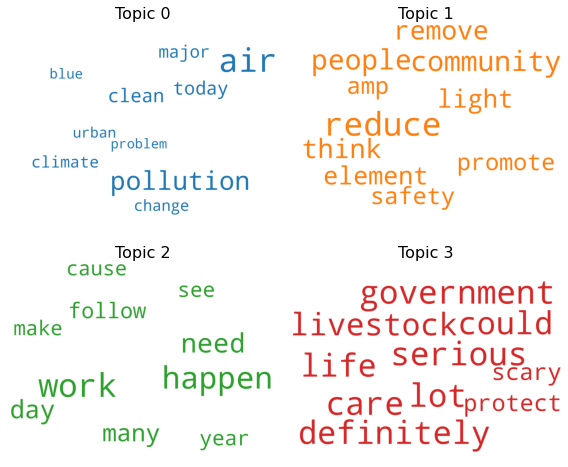

In [45]:
#Word Clouds of Top N Keywords in Each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(8,7), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

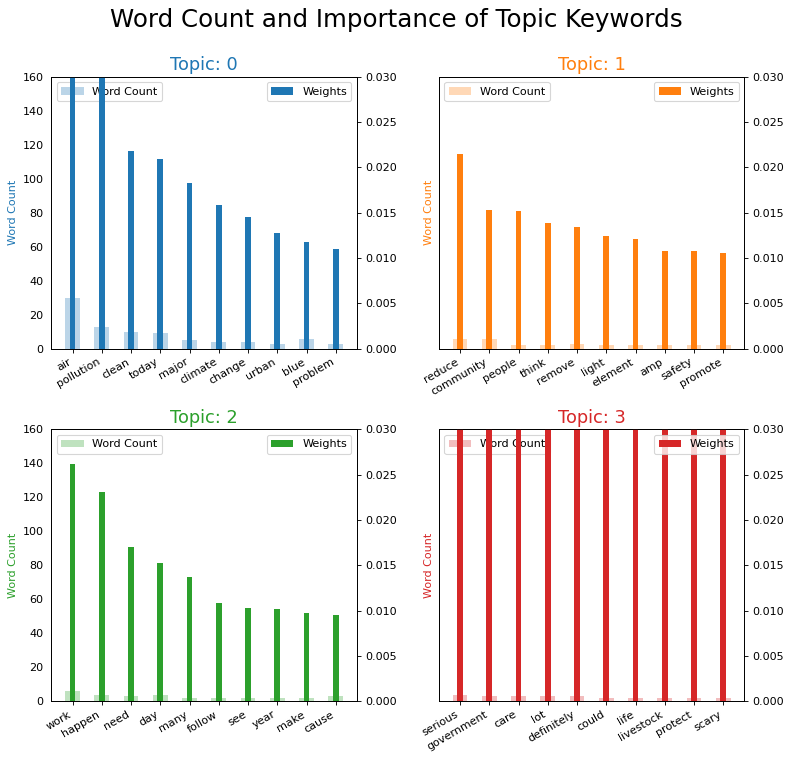

In [46]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,9), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 160)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

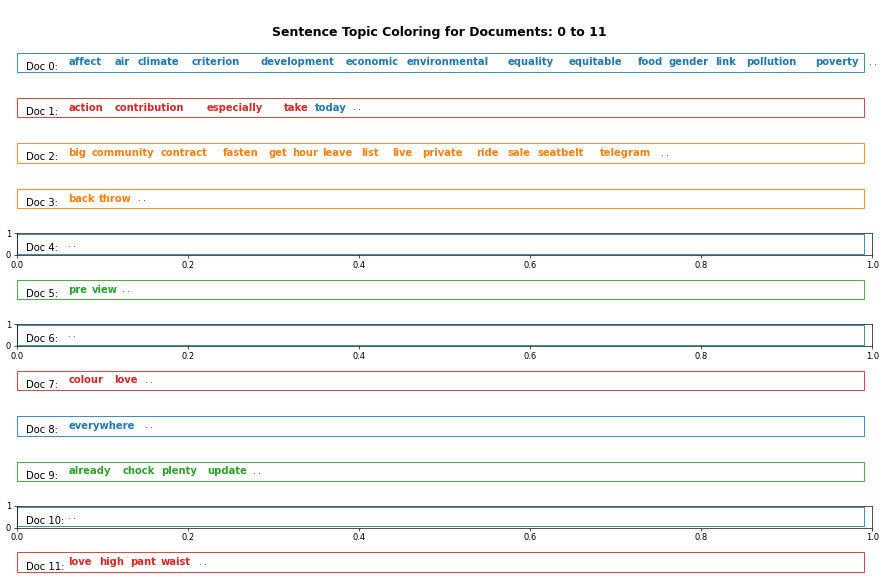

In [47]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(15, (end-start)*0.75), dpi=60)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.3, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=12, color='black', transform=ax.transAxes, fontweight=500)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=1))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . ',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=10, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=15, y=0.95, fontweight=600)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [48]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

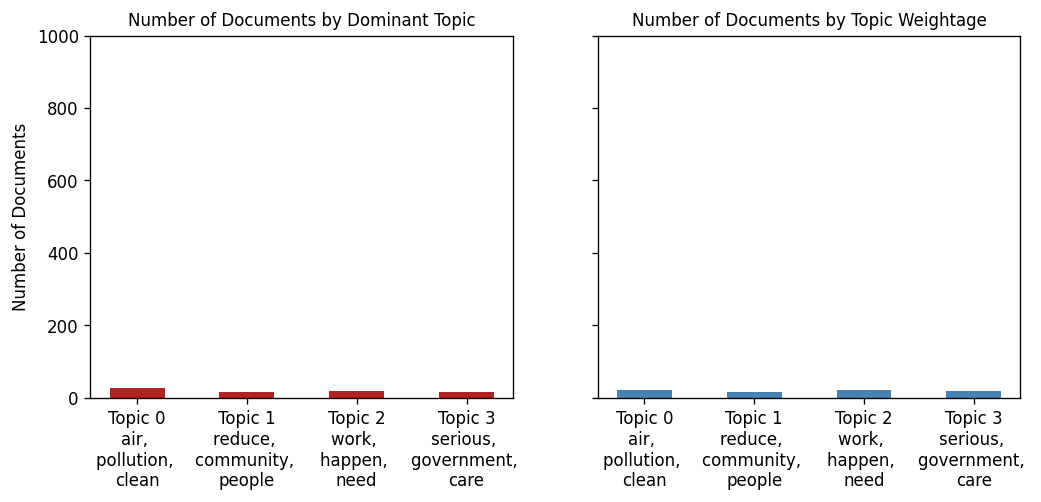

In [49]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [50]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.100240  0.131097       1        1  32.229381
3     -0.242466  0.012166       2        1  24.451076
2      0.071761 -0.074440       3        1  22.287462
1      0.070464 -0.068822       4        1  21.032081, topic_info=           Term       Freq      Total Category  logprob  loglift
1           air  18.000000  18.000000  Default  30.0000  30.0000
386  government   9.000000   9.000000  Default  29.0000  29.0000
265     serious   9.000000   9.000000  Default  28.0000  28.0000
403        care   9.000000   9.000000  Default  27.0000  27.0000
335         lot   8.000000   8.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
355       basic   0.955235   1.423779   Topic4  -5.0161   1.1600
271         use   1.003634   1.517641   Topic4  -4.9667   1.1456
137        burn   1.149019   2.109679   Topic4  -4.8314   0.9515
35         live   0.998858   1.589639   Topic4  -4.9714   1.0945
319      change   1.003472   4.496661   Topic4  -4.9668   0.0593

[168 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
416       3  0.576100   accomplice
357       1  0.609562  achievement
1         1  0.987998          air
236       4  0.690782         also
237       4  0.988693          amp
...     ...       ...          ...
194       3  0.887439         work
74        1  0.572131        world
419       3  0.576100        write
195       3  0.989189         year
432       2  0.839702          yet

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [53]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=300, plot_height=200)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.000s...
[t-SNE] Computed neighbors for 74 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 0.561232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.274269
[t-SNE] KL divergence after 1000 iterations: 0.297570
